In [0]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
# from gensim.models import Word2Vec
# from gensim.models import KeyedVectors
import pickle

import os

from collections import Counter
from scipy.sparse import hstack

from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/IRE_Major_Project/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data = pd.read_csv(root_path+'preprocessed.csv')

In [0]:
data.head()

,id,tweet,new_tweet,user_mentions,n_hash_tags,n_urls,n_emojis,subtask_a,subtask_b,subtask_c,original_tweet_length,new_tweet_length
0,86426,@USER She should ask a few native Americans wh...,she ask native americans their take be,1,0,0,0,OFF,UNT,NaN,14,7
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home you drink maga trump2020,3,2,1,1,OFF,TIN,IND,11,6
2,16820,Amazon is investigating Chinese employees who ...,amazon investigate chinese employees sell inte...,0,5,1,0,NOT,NaN,NaN,27,19
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone should vetaken piece shit volcano,1,0,0,1,OFF,UNT,NaN,11,6
4,43605,@USER @USER Obama wanted liberals &amp; illega...,obama want liberals amp illegals move red state,2,0,0,0,NOT,NaN,NaN,12,8


# *** --changed

In [0]:
data = data[(data['subtask_b'] == 'TIN') | (data['subtask_b'] == 'UNT')]
data.drop(columns  = ['subtask_a' , 'subtask_c'] , inplace  = True)
data.head()

,id,tweet,new_tweet,user_mentions,n_hash_tags,n_urls,n_emojis,subtask_b,original_tweet_length,new_tweet_length
0,86426,@USER She should ask a few native Americans wh...,she ask native americans their take be,1,0,0,0,UNT,14,7
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home you drink maga trump2020,3,2,1,1,TIN,11,6
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone should vetaken piece shit volcano,1,0,0,1,UNT,11,6
5,97670,@USER Liberals are all Kookoo !!!,liberals kookoo,1,0,0,0,TIN,6,2
6,77444,@USER @USER Oh noes! Tough shit.,oh noes tough shit,2,0,0,0,UNT,6,4


# Splitting Data: Train and Test


In [0]:
Y = data['subtask_b']
X = data.drop(['subtask_b','id'],axis=1)
print("Shape of X: ",X.shape)
print("Shape of Y: ",Y.shape)

Shape of X:  (4400, 8)
Shape of Y:  (4400,)


In [0]:
data['subtask_b'].value_counts()

TIN    3876
UNT     524
Name: subtask_b, dtype: int64

In [0]:
#separating data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.30,stratify=Y, random_state=42)
print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ",Y_train.shape)
print("Shape of X_test: ",X_test.shape)
print("Shape of Y_test: ",Y_test.shape)

Shape of X_train:  (3080, 8)
Shape of Y_train:  (3080,)
Shape of X_test:  (1320, 8)
Shape of Y_test:  (1320,)


#### Change the mapping of the label column to binary


In [0]:
Y_train = Y_train.map(dict(TIN=0, UNT=1))
Y_test = Y_test.map(dict(TIN=0, UNT=1))

# Making Data Model Ready: Encoding Tweets

## 1. Bag of Words : Tweets


In [0]:
vectorizer_tweet_bow = CountVectorizer(min_df=5,ngram_range=(1,2))
vectorizer_tweet_bow.fit(X_train['new_tweet'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=5,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [0]:
X_train_tweet_bow = vectorizer_tweet_bow.transform(X_train['new_tweet'])
X_test_tweet_bow = vectorizer_tweet_bow.transform(X_test['new_tweet'])

print("Shape of X_train_tweet_bow ",X_train_tweet_bow.shape)
print("Shape of X_test_tweet_bow ",X_test_tweet_bow.shape)

Shape of X_train_tweet_bow  (3080, 1771)
Shape of X_test_tweet_bow  (1320, 1771)


##2. TF-IDF : Tweets

In [0]:
vectorizer_tweet_tfidf = TfidfVectorizer(min_df=5,ngram_range=(1,2))
vectorizer_tweet_tfidf.fit(X_train['new_tweet'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=5, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [0]:
X_train_tweet_tfidf = vectorizer_tweet_tfidf.transform(X_train['new_tweet'])
X_test_tweet_tfidf = vectorizer_tweet_tfidf.transform(X_test['new_tweet'])

print("Shape of X_train_essay_tfidf ",X_train_tweet_tfidf.shape)
print("Shape of X_test_essay_tfidf ",X_test_tweet_tfidf.shape)

Shape of X_train_essay_tfidf  (3080, 1771)
Shape of X_test_essay_tfidf  (1320, 1771)


##3. Avg W2Vec : Tweets

In [0]:
# average Word2Vec
from scipy.sparse import csr_matrix  ## to make data type consistency across all methods


def get_avg_w2v(corpus):
    with open(root_path+'glove_vectors', 'rb') as f:
      model = pickle.load(f)
      glove_words =  set(model.keys())

    avg_w2v_vectors=[]
    for sentence in tqdm(corpus): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)
    return csr_matrix(avg_w2v_vectors)

In [0]:
X_train_tweet_avg_w2v_vectors = get_avg_w2v(X_train['new_tweet'])
X_test_tweet_avg_w2v_vectors = get_avg_w2v(X_test['new_tweet'])

100%|██████████| 1320/1320 [00:00<00:00, 29879.28it/s]


In [0]:
# print("Shape of X_train_tweet_avg_w2v_vectors",len(X_train_tweet_avg_w2v_vectors),len(X_train_tweet_avg_w2v_vectors[0]))
# print("Shape of X_test_tweet_avg_w2v_vectors ",len(X_test_tweet_avg_w2v_vectors),len(X_test_tweet_avg_w2v_vectors[0]))
print("Shape of X_train_tweet_avg_w2v_vectors",X_train_tweet_avg_w2v_vectors.shape )
print("Shape of X_test_tweet_avg_w2v_vectors ",X_test_tweet_avg_w2v_vectors.shape )

Shape of X_train_tweet_avg_w2v_vectors (3080, 300)
Shape of X_test_tweet_avg_w2v_vectors  (1320, 300)


# Applying Logistic Regression on different featurization of Tweets

## 1. BOW



In [0]:
f1 = X_train_tweet_bow
f2 = X_train['user_mentions'].values.reshape(-1,1)
f3 = X_train['n_hash_tags'].values.reshape(-1,1)
f4 = X_train['n_urls'].values.reshape(-1,1)
f5 = X_train['n_emojis'].values.reshape(-1,1)
X_train_bow_lr =hstack((f1,f2,f3,f4,f5))

# X_train_bow_lr =hstack((f1,f2,f3,f4))
X_train_bow_lr.shape

(3080, 1775)

In [0]:
f1 = X_test_tweet_bow
f2 = X_test['user_mentions'].values.reshape(-1,1)
f3 = X_test['n_hash_tags'].values.reshape(-1,1)
f4 = X_test['n_urls'].values.reshape(-1,1)
f5 = X_test['n_emojis'].values.reshape(-1,1)

# print(type(f1))
X_test_bow_lr =hstack((f1,f2,f3,f4,f5))

# X_test_bow_lr =hstack((f1,f2,f3,f4))
X_test_bow_lr.shape

(1320, 1775)

## Hyper Parameter Tuning: Lambda LogisticRegression

In [0]:
tune_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(class_weight='balanced'), tune_parameters, scoring = 'roc_auc', cv=10, return_train_score=True,n_jobs=-1, verbose=True)
model.fit(X_train_bow_lr, Y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [0]:
results = pd.DataFrame.from_dict(model.cv_results_)
results = results.sort_values(['param_C'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
param_C =  results['param_C']

log_C = [(np.log(x)/np.log(10)) for x in param_C]

plt.plot(log_C, train_auc, label='Train AUC')

plt.plot(log_C, cv_auc, label='CV AUC')

plt.scatter(log_C, train_auc, label='Train AUC points')
plt.scatter(log_C, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log base 10 of C: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

In [0]:
model.best_estimator_

**Obervations:**

1. We can see both from the graph as well as from the API response that the best value of C = 0.01

2. This can be seen as value of -2 on the x-axis of the error vs logC plot.

In [0]:
lr_bow = model.best_estimator_
lr_bow.fit(X_train_bow_lr,Y_train)

y_train_pred = lr_bow.predict_proba(X_train_bow_lr)
y_test_pred = lr_bow.predict_proba(X_test_bow_lr)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train.values, y_train_pred[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test.values, y_test_pred[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()

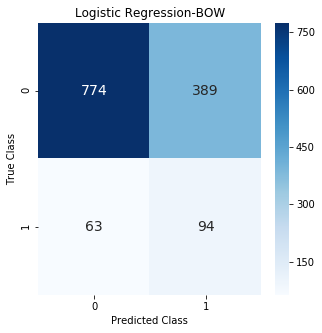

In [0]:
y_test_predict = lr_bow.predict(X_test_bow_lr)

results = confusion_matrix(Y_test, y_test_predict)
plt.figure(figsize = (5,5))
ax = sns.heatmap(results, cmap="Blues", annot=True,annot_kws={"size": 14},fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Logistic Regression-BOW')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [0]:
print("F1 Score = " + str(f1_score(Y_test,y_test_predict,average= 'macro') ))

F1 Score = 0.533875


### Misclassified examples

In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict)

In [0]:
print(y_test_predict)

[0 0 0 ... 1 0 0]


In [0]:
def print_stuff(idx):
  global y_test_pred # probabilities
  global X_test
  global y_test #original class
  global y_test_predict #predicted class
  # preprocessed_tweet
  print('preprocessed tweet')
  print(X_test.iloc[idx,1])
  # computed prob
  print('computed prob: ',y_test_pred[idx], 'class predicted: ',y_test_predict[idx])
  print('original class: ',y_test[idx])

In [0]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

452 misclassifications


In [0]:
def prRed(skk): print("\033[91m {}\033[00m" .format(skk)) 
def prGreen(skk): print("\033[92m {}\033[00m" .format(skk)) 

Red: original Targeted insult (0), classified as untargeted (1) <br>
Green: original untargeted (1), classified as Targeted insult (0)

In [0]:
limit = 10
counts = [0] *2
for index in misclassified[0]:
  if limit in counts:
    break
  #original not offensive (0), classified as offensive (1) 
  if y_test[index] == 0 and y_test_predict[index] == 1:
    prRed(X_test.iloc[index,0])
    print_stuff(index)
    counts[0] += 1
  #original offensive (1), classified as not offensive (0)
  elif y_test[index] == 1 and y_test_predict[index] == 0:
    prGreen(X_test.iloc[index,0])
    print_stuff(index)
    counts[1] += 1

 @USER Another overdose nigga:(
preprocessed tweet
another overdose nigga
computed prob:  [0.46223739 0.53776261] class predicted:  1
original class:  0
 @USER Everyone in Washington including John Heinz is being uncovered as the corrupt elites they are...Like cockroaches running from the light.
preprocessed tweet
everyone washington include john heinz uncover corrupt elites they be like cockroaches run light
computed prob:  [0.46899615 0.53100385] class predicted:  1
original class:  0
 @USER @USER @USER @USER I wasn't proposing scare tactics. I really meant what I said. Trump can easily pull the good maga Republicans and can easily steal enough votes from GOP Dem and independents and will bring fresh breath to our rotten politics. Think about it.
preprocessed tweet
i not propose scare tactics i really mean i say trump easily pull good maga republicans easily steal enough vote gop dem independents bring fresh breath our rotten politics think it
computed prob:  [0.49259546 0.50740454] 

## 2. TF-IDF


In [0]:
f1 = X_train_tweet_tfidf
f2 = X_train['user_mentions'].values.reshape(-1,1)
f3 = X_train['n_hash_tags'].values.reshape(-1,1)
f4 = X_train['n_urls'].values.reshape(-1,1)
f5 = X_train['n_emojis'].values.reshape(-1,1)

# print(type(f1))
X_train_tfidf =hstack((f1,f2,f3,f4,f5))

# X_train_tfidf =hstack((f1,f2,f3,f4))
X_train_tfidf.shape

(3080, 1775)

In [0]:
f1 = X_test_tweet_tfidf
f2 = X_test['user_mentions'].values.reshape(-1,1)
f3 = X_test['n_hash_tags'].values.reshape(-1,1)
f4 = X_test['n_urls'].values.reshape(-1,1)
f5 = X_test['n_emojis'].values.reshape(-1,1)
X_test_tfidf =hstack((f1,f2,f3,f4,f5))

# X_test_tfidf =hstack((f1,f2,f3,f4))
X_test_tfidf.shape

(1320, 1775)

## Hyperparameter Tuning LogisticRegression

In [0]:
tune_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(class_weight='balanced'), tune_parameters, scoring = 'roc_auc', cv=10, return_train_score=True,n_jobs=-1, verbose=True)
model.fit(X_train_tfidf, Y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.5s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'C': [0.0001, 0.01, 1, 100, 10000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=True)

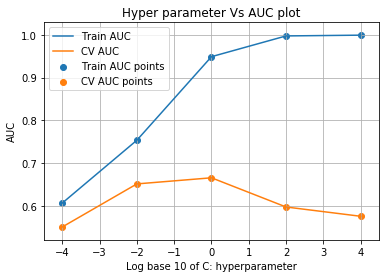

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.011034,0.002349,0.002422,0.000227,0.0001,{'C': 0.0001},0.487977,0.461645,0.603786,0.607759,0.602673,0.536701,0.614690,0.503895,0.610599,0.474170,0.550378,0.060477,5,0.570399,0.567526,0.702685,0.675576,0.624730,0.570878,0.564470,0.560588,0.657886,0.568974,0.606371,0.051351
1,0.014599,0.002985,0.002299,0.000170,0.01,{'C': 0.01},0.648251,0.558824,0.658138,0.681959,0.628204,0.618580,0.729381,0.659287,0.669639,0.659697,0.651156,0.042125,2,0.751701,0.751796,0.755304,0.769345,0.752093,0.750269,0.750766,0.743766,0.756997,0.751949,0.753399,0.006242
2,0.024326,0.002327,0.002403,0.000210,1,{'C': 1},0.646165,0.542528,0.662709,0.685449,0.662312,0.637529,0.733769,0.683989,0.715252,0.685527,0.665447,0.049612,1,0.948962,0.951281,0.951283,0.949308,0.947315,0.948979,0.947838,0.948444,0.947468,0.948605,0.948948,0.001322
3,0.073622,0.006193,0.003010,0.000133,100,{'C': 100},0.557432,0.490560,0.611238,0.580732,0.616735,0.603321,0.615887,0.621054,0.660209,0.614801,0.597120,0.043664,3,0.997106,0.997266,0.997134,0.997615,0.998194,0.997926,0.997673,0.997440,0.997081,0.997617,0.997505,0.000353
4,0.172275,0.015940,0.002912,0.000410,10000,{'C': 10000},0.524145,0.490759,0.575169,0.543632,0.608756,0.597736,0.583076,0.587638,0.643091,0.600554,0.575377,0.042249,4,0.999286,0.999233,0.999402,0.999278,0.999228,0.999466,0.999312,0.999344,0.999239,0.999435,0.999322,0.000082


In [0]:
results = pd.DataFrame.from_dict(model.cv_results_)
results = results.sort_values(['param_C'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
param_C =  results['param_C']

log_C = [(np.log(x)/np.log(10)) for x in param_C]

plt.plot(log_C, train_auc, label='Train AUC')

plt.plot(log_C, cv_auc, label='CV AUC')

plt.scatter(log_C, train_auc, label='Train AUC points')
plt.scatter(log_C, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log base 10 of C: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

In [0]:
model.best_estimator_

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

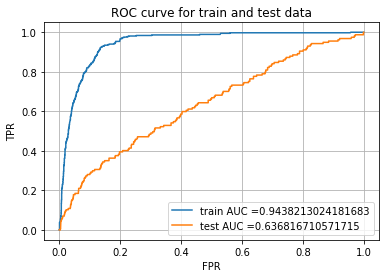

In [0]:
lr_tfidf = model.best_estimator_
lr_tfidf.fit(X_train_tfidf,Y_train)

y_train_pred = lr_tfidf.predict_proba(X_train_tfidf)
y_test_pred = lr_tfidf.predict_proba(X_test_tfidf)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()

              precision    recall  f1-score   support

           0       0.91      0.80      0.85      1163
           1       0.21      0.38      0.27       157

    accuracy                           0.75      1320
   macro avg       0.56      0.59      0.56      1320
weighted avg       0.82      0.75      0.78      1320



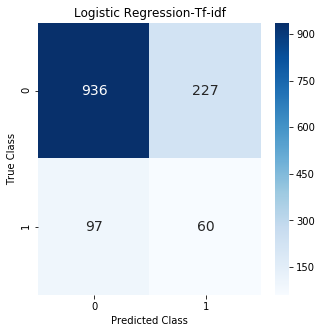

In [0]:
y_test_predict = lr_tfidf.predict(X_test_tfidf)

results = confusion_matrix(Y_test, y_test_predict)
print(classification_report(Y_test, y_test_predict))
plt.figure(figsize = (5,5))
ax = sns.heatmap(results, cmap="Blues", annot=True,annot_kws={"size": 14},fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Logistic Regression-Tf-idf')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [0]:
print("F1 Score = " + str(f1_score(Y_test,y_test_predict,average= 'macro') ))

F1 Score = 0.5613646433318564


### Misclassified examples

In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict)

In [0]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

324 misclassifications


Red: original Targeted insult (0), classified as untargeted (1) <br>
Green: original untargeted (1), classified as Targeted insult (0)

In [0]:
limit = 10
counts = [0] *2
for index in misclassified[0]:
  if limit in counts:
    break
  #original not offensive (0), classified as offensive (1) 
  if y_test[index] == 0 and y_test_predict[index] == 1:
    prRed(X_test.iloc[index,0])
    print_stuff(index)
    counts[0] += 1
  #original offensive (1), classified as not offensive (0)
  elif y_test[index] == 1 and y_test_predict[index] == 0:
    prGreen(X_test.iloc[index,0])
    print_stuff(index)
    counts[1] += 1

 @USER Another overdose nigga:(
preprocessed tweet
another overdose nigga
computed prob:  [0.34882727 0.65117273] class predicted:  1
original class:  0
 @USER Everyone in Washington including John Heinz is being uncovered as the corrupt elites they are...Like cockroaches running from the light.
preprocessed tweet
everyone washington include john heinz uncover corrupt elites they be like cockroaches run light
computed prob:  [0.46871174 0.53128826] class predicted:  1
original class:  0
 @USER We are “Casually fucked”
preprocessed tweet
we casually fuck
computed prob:  [0.19893825 0.80106175] class predicted:  1
original class:  0
 @USER Behold all the conservatives who deliberately ignore the fact that the OK gesture USED TO BE benign but now is co-opted by racists to signal they're down with white supremacy. Much like swastikas were benign in Asian countries (&amp; still are) but were co-opted &amp; ruined by Nazis.
preprocessed tweet
behold conservatives deliberately ignore fact ok 

# 3. AvgW2Vec 

In [0]:
f1 = X_train_tweet_avg_w2v_vectors
f2 = X_train['user_mentions'].values.reshape(-1,1)
f3 = X_train['n_hash_tags'].values.reshape(-1,1)
f4 = X_train['n_urls'].values.reshape(-1,1)
f5 = X_train['n_emojis'].values.reshape(-1,1)
X_train_w2vec =hstack((f1,f2,f3,f4,f5))

# X_train_w2vec =hstack((f1,f2,f3,f4))
X_train_w2vec.shape

(3080, 304)

In [0]:
f1 = X_test_tweet_avg_w2v_vectors
f2 = X_test['user_mentions'].values.reshape(-1,1)
f3 = X_test['n_hash_tags'].values.reshape(-1,1)
f4 = X_test['n_urls'].values.reshape(-1,1)
f5 = X_test['n_emojis'].values.reshape(-1,1)

X_test_w2vec =hstack((f1,f2,f3,f4,f5))

# X_test_w2vec =hstack((f1,f2,f3,f4))
X_test_w2vec.shape

(1320, 304)

## Hyper parameter tuning LogisticRegression

In [0]:
tune_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(class_weight='balanced'), tune_parameters, scoring = 'roc_auc', cv=10, return_train_score=True,n_jobs=-1, verbose=True)
model.fit(X_train_w2vec, Y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   21.2s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'C': [0.0001, 0.01, 1, 100, 10000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=True)

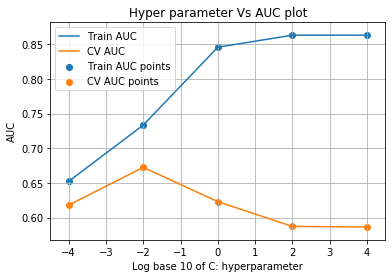

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.099016,0.013952,0.003176,0.000540,0.0001,{'C': 0.0001},0.627285,0.556737,0.567220,0.720804,0.627805,0.637379,0.689538,0.558323,0.581693,0.614289,0.618106,0.052416,3,0.635272,0.640676,0.668865,0.678042,0.666852,0.651278,0.645868,0.632604,0.664589,0.638456,0.652250,0.015320
1,0.182730,0.005608,0.002983,0.000094,0.01,{'C': 0.01},0.712937,0.648649,0.665789,0.720006,0.638975,0.651242,0.711579,0.656827,0.658262,0.659902,0.672434,0.028673,1,0.730988,0.737615,0.730873,0.734770,0.736899,0.739639,0.729544,0.729401,0.729745,0.734697,0.733417,0.003591
2,0.679871,0.017393,0.002995,0.000199,1,{'C': 1},0.619336,0.535970,0.644823,0.639623,0.597088,0.573352,0.690835,0.658569,0.675892,0.595223,0.623029,0.045742,2,0.846486,0.850521,0.844553,0.843416,0.850513,0.849385,0.840986,0.843744,0.845779,0.841416,0.845680,0.003340
3,1.409361,0.038100,0.003024,0.000174,100,{'C': 100},0.581479,0.526232,0.594843,0.585270,0.561484,0.547023,0.653037,0.607729,0.647909,0.568573,0.587318,0.038566,4,0.862176,0.866991,0.863505,0.860050,0.867497,0.865634,0.860412,0.862308,0.864507,0.856422,0.862950,0.003247
4,1.421925,0.032967,0.002915,0.000354,10000,{'C': 10000},0.580286,0.527723,0.594147,0.585070,0.560985,0.545826,0.650942,0.604961,0.647396,0.568573,0.586553,0.037921,5,0.862217,0.867104,0.863662,0.860048,0.867479,0.865474,0.860555,0.862468,0.864591,0.856491,0.863009,0.003224


In [0]:
results = pd.DataFrame.from_dict(model.cv_results_)
results = results.sort_values(['param_C'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
param_C =  results['param_C']

log_C = [(np.log(x)/np.log(10)) for x in param_C]

plt.plot(log_C, train_auc, label='Train AUC')

plt.plot(log_C, cv_auc, label='CV AUC')

plt.scatter(log_C, train_auc, label='Train AUC points')
plt.scatter(log_C, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log base 10 of C: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

In [0]:
model.best_estimator_

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

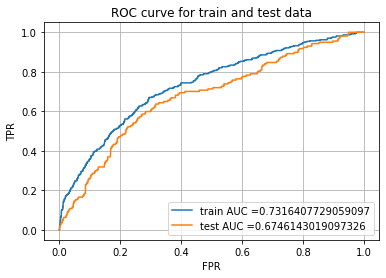

In [0]:
lr_w2vec = model.best_estimator_
lr_w2vec.fit(X_train_w2vec,Y_train)

y_train_pred = lr_w2vec.predict_proba(X_train_w2vec)
y_test_pred = lr_w2vec.predict_proba(X_test_w2vec)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()

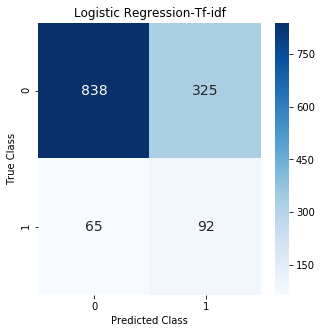

In [0]:
y_test_predict = lr_w2vec.predict(X_test_w2vec)

results = confusion_matrix(Y_test, y_test_predict)
plt.figure(figsize = (5,5))
ax = sns.heatmap(results, cmap="Blues", annot=True,annot_kws={"size": 14},fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Logistic Regression-Tf-idf')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [0]:
print("F1 Score = " + str(f1_score(Y_test,y_test_predict,average= 'macro') ))

F1 Score = 0.5658934600686071


### Misclassified examples

In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict)

In [0]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

390 misclassifications


Red: original Targeted insult (0), classified as untargeted (1) <br>
Green: original untargeted (1), classified as Targeted insult (0)

In [0]:
limit = 10
counts = [0] *2
for index in misclassified[0]:
  if limit in counts:
    break
  #original not offensive (0), classified as offensive (1) 
  if y_test[index] == 0 and y_test_predict[index] == 1:
    prRed(X_test.iloc[index,0])
    print_stuff(index)
    counts[0] += 1
  #original offensive (1), classified as not offensive (0)
  elif y_test[index] == 1 and y_test_predict[index] == 0:
    prGreen(X_test.iloc[index,0])
    print_stuff(index)
    counts[1] += 1

 @USER Time to vote and spit in the eye of all these liberals
preprocessed tweet
time vote spit eye liberals
computed prob:  [0.46724863 0.53275137] class predicted:  1
original class:  0
 @USER Another overdose nigga:(
preprocessed tweet
another overdose nigga
computed prob:  [0.42203599 0.57796401] class predicted:  1
original class:  0
 @USER Behold all the conservatives who deliberately ignore the fact that the OK gesture USED TO BE benign but now is co-opted by racists to signal they're down with white supremacy. Much like swastikas were benign in Asian countries (&amp; still are) but were co-opted &amp; ruined by Nazis.
preprocessed tweet
behold conservatives deliberately ignore fact ok gesture use benign co opt racists signal they re white supremacy much like swastikas benign asian countries amp still be co opt amp ruin nazis
computed prob:  [0.48264169 0.51735831] class predicted:  1
original class:  0
 @USER the owner of my culo
preprocessed tweet
owner my culo
computed prob: 